We run the main analysis script which imports the necessary libraries and provides all our functions

In [39]:
%pylab inline
import seaborn as sns
from numpy import sort,hstack
%run src/analyse.py 

### Reading the reference 

We read the reference genome and parse it to obtain the masked regions. These regions will be relevant when we are sampling random mutations for our null model. 

We are not interested in mitochondria or chloroplast in this work so we remove them from the samples.

In [2]:
TAIR10 = 'reference/TAIR10-masked.fa'

chromosomes  = dict()  # chromosome sequences
chrSize      = dict()  # chromosome sizes, for convenience
maskedRanges = dict()  # masked ranges in each chromosome

for chromosome in SeqIO.parse(TAIR10, 'fasta', generic_dna) :
    name, seq  = chromosome.name, chromosome.seq
    
    # ignore chloroplast and mitochondria
    if name == 'chloroplast' or name == 'mitochondria' : continue
    
  #  chromosomes[name]  = seq  # we don't really need the actual sequence beyond this loop, save some memory
    chrSize[name]      = len(seq) 
    maskedRanges[name] = get_masked_ranges(seq)
    
    # get total size of masked regions
    maskedSize = sum(map(lambda x : x[1]-x[0], maskedRanges[name]))
    
    print '{} is of length {}, covered {:.1f}% by masked regions'.format\
    (name, chrSize[name], maskedSize*100.0/chrSize[name])

Chr1 is of length 30427671, covered 15.1% by masked regions
Chr2 is of length 19698289, covered 21.1% by masked regions
Chr3 is of length 23459830, covered 18.0% by masked regions
Chr4 is of length 18585056, covered 20.1% by masked regions
Chr5 is of length 26975502, covered 16.5% by masked regions


In [3]:
# chromosome namelist for convenience
chrNames = chrSize.keys()
chrNames.sort()

### Reading the vcf file

We parse the vcf file that was generated in the final step of the variant calling workflow to obtain all the heterozygous variants.
We call the function 

`get_hetero_variants(vcfFile, snpMinGQ=50, indelMinGQ=30, minAD=5)`

which extracts heterozygous variants that satisfy minimum genotype quality (GQ) and alelle depth (AD) requirements. 
The default values reflect the reported filters in the original publication. 

`get_hetero_variants()` returns **sample counts** for each genotype in each variant position, in each chromosome. It does not return per-sample information.


In [4]:
vcfFile = 'calls/genotype.vcf'

hetSNPs, hetIndels = get_hetero_variants(vcfFile)

In [5]:
for ch in chrNames :
    print '{}: {:6d}/{} hetero SNPs/indels, total: {}'.format \
    (ch, len(hetSNPs[ch]), len(hetIndels[ch]), len(hetSNPs[ch])+len(hetIndels[ch]))

Chr1: 141016/35974 hetero SNPs/indels, total: 176990
Chr2:  79041/19656 hetero SNPs/indels, total: 98697
Chr3: 102039/24587 hetero SNPs/indels, total: 126626
Chr4:  89621/22595 hetero SNPs/indels, total: 112216
Chr5: 133333/33662 hetero SNPs/indels, total: 166995


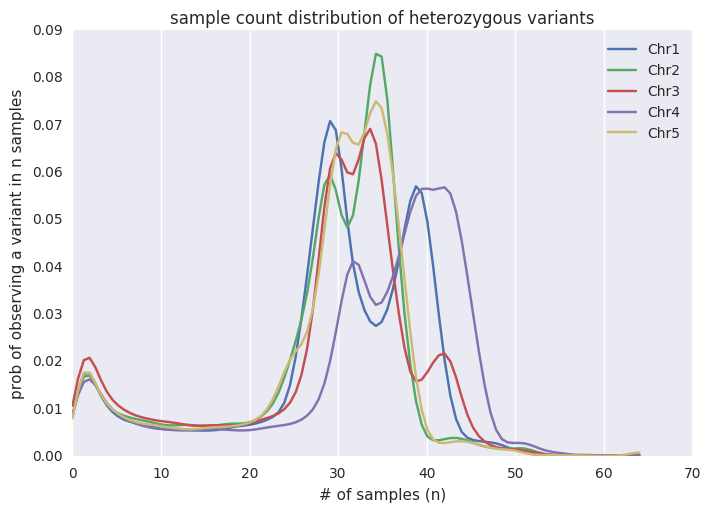

In [6]:
for ch in chrNames:
    counts = array([ counts['0/1'] for counts in hetSNPs[ch].values()])
    #ax=sns.distplot(counts, kde_kws={'cut':0} )
    ax=sns.kdeplot(counts, cut=0, label=ch)

sns.plt.legend()
ax.grid(axis='y')
ax.set_title('sample count distribution of heterozygous variants')
ax.set_ylabel('prob of observing a variant in n samples')
ax.set_xlabel('# of samples (n)')

Wherever the parent (f1) is heterozygous, we expect half of the progeny (f2) samples (32) to be heterozygous. 
Although this expectation holds, *the bimodal distribution around 32 is a little weird*. 
Maybe there is a biological mechanism that I don't know about that results in this. 

We also observe another peak around 1 which signifies denovo mutations. 
If a hetero variant is observed in a single sequence, we can safely claim a denovo mutation, but what if it is observed in 2 or 3 samples? 
That part is clearly out of the tail of the peak around 32. 
What is going on here? I don't know.

### Denovo vs. inherited variation

If we observe a heterozygous variant in more than *minInherit* samples  we claim this was inherited, therefore **f1 was heterozygous in these positions** 

If we observe a heterozygous variant in a maximum of *maxDenovo* samples, we claim **a sample in f2 has a denovo mutation in this position** 

`process_hetero_variants (variants, minInherit=10, maxDenovo=1)` 

thus splits heretozygous variants into **inherited** and **denovo** partitions. 



In [7]:
hetero_variants = dict()

for ch in chrNames :
    inheritSNPs, denovoSNPs = process_hetero_variants(hetSNPs[ch])
    inheritIndels, denovoIndels = process_hetero_variants(hetIndels[ch])
    
    thisChromosome = dict()
    
    thisChromosome['inheritSNPs'] = inheritSNPs
    thisChromosome['inheritIndels'] = inheritIndels
    thisChromosome['denovoSNPs'] = denovoSNPs
    thisChromosome['denovoIndels'] = denovoIndels
    # combined indels and snps 
    thisChromosome['denovoAll'] = sort(hstack([denovoSNPs, denovoIndels]))
    thisChromosome['inheritAll']= sort(hstack([inheritSNPs, inheritIndels]))
    
    
    hetero_variants[ch]=thisChromosome
    
    print '{}: inherited: {:6d}/{:5d} SNPs/indels, denovo: {}/{} SNPs/indels '.format \
    (ch, len(inheritSNPs), len(inheritIndels), len(denovoSNPs), len(denovoIndels) )
    

Chr1: inherited: 126255/30515 SNPs/indels, denovo: 4174/2054 SNPs/indels 
Chr2: inherited:  70455/16571 SNPs/indels, denovo: 2329/1281 SNPs/indels 
Chr3: inherited:  88765/20375 SNPs/indels, denovo: 3763/1643 SNPs/indels 
Chr4: inherited:  80184/19333 SNPs/indels, denovo: 2728/1248 SNPs/indels 
Chr5: inherited: 119098/28825 SNPs/indels, denovo: 3877/1867 SNPs/indels 


### Measure

The essence of this hypothesis is in the distance between the denovo mutations and the heterozygous regions in the parent genome. 

`get_hetero_distances(denovo, hetero)` takes two lists of positions and will calculate the distance of each denovo mutation to the closest heterozygous mutation. 

Because it is not trivial how to deal with snps vs. indels, we might as well do this thrice, for snps, indels and combined. 


Let's do this for SNPs first : 

In [42]:
hetero_distances = dict()

for ch in chrNames :
    
    thisChr = hetero_variants[ch]
    
    dist = dict()
    
    # for snps
    dist['snp'] = get_hetero_distances(thisChr['denovoSNPs'], thisChr['inheritSNPs'])
    
    # for indels

    dist['indel'] = get_hetero_distances( thisChr['denovoIndels'], thisChr['inheritIndels'] )
    
    # combined

    dist['combined'] = get_hetero_distances(thisChr['denovoAll'], thisChr['inheritAll'])
    
    hetero_distances[ch]=dist
    
    print ch, mean(dist['snp']), mean(dist['indel']), mean(dist['combined'])
    print ch, std(dist['snp']), std(dist['indel']), std(dist['combined'])


Chr1 260.135122185 1308.87925998 225.931599229
Chr1 1343.60038361 6209.50259648 956.328476142
Chr2 297.264920567 1097.53786105 277.906371191
Chr2 1407.54769822 3455.97099381 1416.46459332
Chr3 258.634334308 1286.89531345 235.231409545
Chr3 1013.92091444 4010.69301373 1020.94566739
Chr4 506.761363636 910.356570513 402.881790744
Chr4 3334.51986412 2978.89818976 2815.01135891
Chr5 211.622646376 980.467595072 203.993036212
Chr5 1443.02716261 3768.59789137 1509.70576244


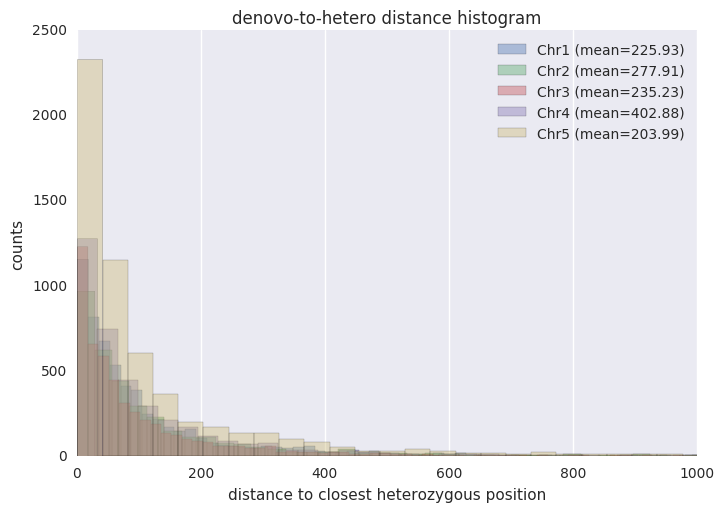

In [9]:
for ch in chrNames:
    dist = hetero_distances[ch]['combined']
    ax=sns.distplot(dist, kde=False, bins=1500, label='{} (mean={:.2f})'.format(ch,mean(dist)))
    #ax=sns.kdeplot(hetero_distances[ch]['combined'], cut=0, label=ch)

sns.plt.legend()
ax.grid(axis='y')
ax.set_title('denovo-to-hetero distance histogram')
ax.set_ylabel('counts')
ax.set_xlabel('distance to closest heterozygous position')
ax.set_xbound(upper=1000)
#ax.set_xscale('log')


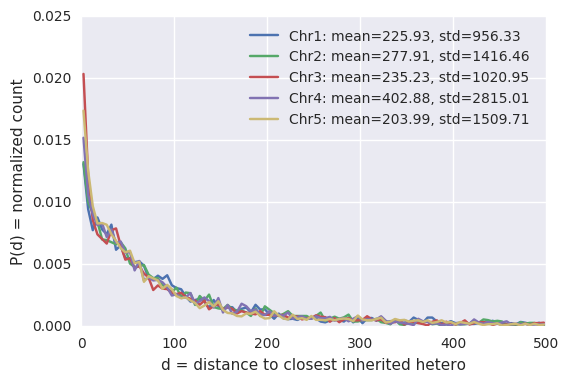

In [93]:

bins = array(range(0,10000,5))
x= 0.5*(bins[:-1]+bins[1:])
cutoff = 100

for ch in chrNames :
    dist = hetero_distances[ch]['combined']
    tmp=histogram(dist , bins=bins, normed=True)
    plot (x[:cutoff], tmp[0][:cutoff], label='{}: mean={:.2f}, std={:.2f} '.format(ch,mean(dist),std(dist)) )


xlabel('d = distance to closest inherited hetero')
ylabel('P(d) = normalized count')
legend()

We can easily see that these are heavy tailed distributions. 
I had to cut the tails out of plots, and means are not necessarily informative in such distributions. 

### Null model


We now have the observed mutation-to-hetero distances per chromosome. It is time to compare it to a **null model**. 

We build a null model by sampling the same number of positions randomly from the chromosome and measuring the average distance to the closest heterozygous position. 

We repeat the experiment `nullsamples` times and report mean and std for the null model.

We report the observed value versus the mean and std of the null model to attempt to reject the null.

In [10]:
nullSamples = 10

null_model = dict()

for ch in chrNames :
    null_dist = list()
    ndenovo = len(hetero_variants[ch]['denovoAll'])
    
    for i in range(nullSamples) :
        null_denovo = sample_mutations(ndenovo, maskedRanges[ch], chrSize[ch] )
        null_dist.append (mean(get_hetero_distances(null_denovo, hetero_variants[ch]['inheritAll'])))
    
    null_model[ch] = null_dist
    
    print '{}: observed: {:.2f} null: {:.2f}/{:.2f} mean/std'.format\
    (ch, mean(hetero_distances[ch]['combined']), mean(null_dist), std(null_dist))

Chr1: observed: 225.93 null: 975.32/33.80 mean/std
Chr2: observed: 277.91 null: 569.94/27.33 mean/std
Chr3: observed: 235.23 null: 604.69/17.65 mean/std
Chr4: observed: 402.88 null: 501.70/25.07 mean/std
Chr5: observed: 203.99 null: 885.21/78.08 mean/std


It looks like we have good reason to reject the null hypothesis.

### Complete null model

If we sample all non-masked positions in each chromosome rather than some number of mutations, we can see the convergent state of our null model, this will give us a maximally informed distribution. 

We will call this complete_null in code or **null<sub>c</sub>** in documentation from now on.

In [11]:
complete_null = dict()

for ch in chrNames :
    # get all the non-masked positions 
    allChromosome = list()
    here = 0 
    # add all the segments between the masked regions
    for r in maskedRanges[ch] : 
        allChromosome += range(here, r[0])
        here = r[1]
    # add the tail end
    allChromosome += range(here, chrSize[ch])
    
    # convert to numpy array for distance calculation 
    allChromosome = array(sorted(allChromosome), dtype=int)

    dist = get_hetero_distances(allChromosome, hetero_variants[ch]['inheritAll'])
    
    complete_null[ch] = dist
    
    print ch, mean(dist), std(dist)

Chr1 958.018079402 3668.13066964
Chr2 593.802533603 1979.95117983
Chr3 608.337100031 1680.06338946
Chr4 510.0753485 1984.46746694
Chr5 886.245811766 5011.90156586


We can see that std is much larger in null<sub>c</sub>. 
These appear to be <del>power law</del> heavy tailed distributions, which means the second moment (std) is divergent and first moment (mean) might not be very informative. 

It might be a good idea to approach with a information theoretical measure involving whole distributions rather than simple moments to this analysis. 

Let us repeat the analysis using [KL distances](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence).

We can measure the kl distance between the sampled null model vs. null<sub>c</sub> which would essentially go to 0 as the sample size goes to the size of chromosome(-masked regions).

We can compare this with the kl distance of the observed distribution vs. the null<sub>c</sub>.

In [26]:
for ch in chrNames :
    
    # distribution for the complete null model 
    all_dist = get_discrete_dist(complete_null[ch])
    
    # distribution for the observed distances
    exp_dist = get_discrete_dist(hetero_distances[ch]['combined'])
    
    # kl distance between observed and complete null model
    exp_kl = kl_dist(exp_dist, all_dist)
        
    null_kl = list()
    ndenovo = len(hetero_variants[ch]['denovoAll'])

    for i in range(nullSamples) :
        
        # sample ndenovo random mutations
        null_denovo = sample_mutations(ndenovo, maskedRanges[ch], chrSize[ch] )
         
        # get distances from closest hetero positions
        null_distances = get_hetero_distances(null_denovo, hetero_variants[ch]['inheritAll'])
        
        # get distance distribution
        null_dist = get_discrete_dist(null_distances)
        
        # kl distance between sampled dist and complete null
        null_kl.append(kl_dist(null_dist, all_dist))
            
    print '{}: observed: {:.2f} null: {:.2f}/{:.2f} mean/std kl distance'.format\
    (ch, exp_kl, mean(null_kl), std(null_kl))

Chr1: observed: 0.36 null: 0.45/0.01 mean/std kl distance
Chr2: observed: 0.40 null: 0.46/0.01 mean/std kl distance
Chr3: observed: 0.41 null: 0.39/0.01 mean/std kl distance
Chr4: observed: 0.39 null: 0.38/0.02 mean/std kl distance
Chr5: observed: 0.32 null: 0.39/0.01 mean/std kl distance


Now the observed distribution appears closer to the null<sub>c</sub> than the sampled distribution. What? I did not see this one coming. 

Let's try the better behaved js distance. 

In [41]:
for ch in chrNames :
    
    # distribution for the observed distances
    exp_dist = get_discrete_dist(hetero_distances[ch]['combined'])
    

    null_kl = list()
    ndenovo = len(hetero_variants[ch]['denovoAll'])

    for i in range(nullSamples) :
        
        # sample ndenovo random mutations
        null_denovo = sample_mutations(ndenovo, maskedRanges[ch], chrSize[ch] )
         
        # get distances from closest hetero positions
        null_distances = get_hetero_distances(null_denovo, hetero_variants[ch]['inheritAll'])
        
        # get distance distribution
        null_dist = get_discrete_dist(null_distances)
        
        # kl distance between sampled dist and complete null
        null_kl.append(js_dist(null_dist, exp_dist))
            
    print '{}: {:.2f}/{:.2f} mean/std js distance'.format\
    (ch, mean(null_kl), std(null_kl))

Chr1: 0.12/0.00 mean/std js distance
Chr2: 0.14/0.00 mean/std js distance
Chr3: 0.13/0.00 mean/std js distance
Chr4: 0.12/0.00 mean/std js distance
Chr5: 0.11/0.00 mean/std js distance


Adding a plot dor demonstration purposes

In [81]:
for ch in ['Chr1'] :
    
    # distribution for the observed distances
    obs_distances = hetero_distances[ch]['combined']
     

    ndenovo = len(hetero_variants[ch]['denovoAll'])
    
    # sample ndenovo random mutations
    null_denovo = sample_mutations(ndenovo, maskedRanges[ch], chrSize[ch] )
     
    # get distances from closest hetero positions
    null_distances = get_hetero_distances(null_denovo, hetero_variants[ch]['inheritAll'])
        


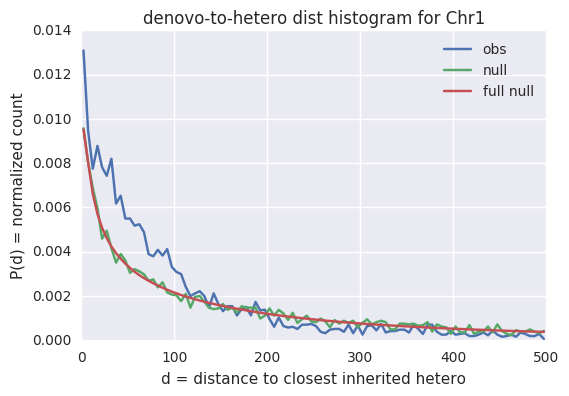

In [85]:

bins = array(range(0,10000,5))
x= 0.5*(bins[:-1]+bins[1:])

a=histogram(obs_distances, bins=bins, normed=True)
b=histogram(null_distances, bins=bins, normed = True) 
c=histogram(complete_null[ch], bins=bins, normed = True) 

cutoff = 100

plot (x[:cutoff], a[0][:cutoff], label = 'obs')
plot (x[:cutoff], b[0][:cutoff],label= 'null')
plot (x[:cutoff], c[0][:cutoff],label= 'full null')


title('denovo-to-hetero dist histogram for Chr1')
xlabel('d = distance to closest inherited hetero')
ylabel('P(d) = normalized count')
legend()